# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Описание данных
Признаки

* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — количество недвижимости у клиента
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак

* Exited — факт ухода клиента

 ### Оглавление <a class="anchor" id="0-bullet"></a>

* [Подготовка данных](#1-bullet)
* [Исследование задачи](#2-bullet)
* [Тестирование модели](#3-bullet)
* [Вывод](#4-bullet)

# 1. Подготовка данных <a class="anchor" id="1-bullet"></a>

[Обратно в оглавление](#0-bullet)

Подключим библиотеки

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
import numpy as np

import warnings

from random import *

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

Откроем файл

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
display(data.info())
display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


* Переведем название колонок в нижний регистр
* Значения в столбце tenure приведем к целочисленным
* Остаток на счете и предполагаемую зарплату округлим до целого числа, так как дробная часть несущественна, когда порядки чисел сотни и десятки тысяч

In [3]:
display(data.groupby('Age')['Age'].count())

Age
18    22
19    27
20    40
21    53
22    84
      ..
83     1
84     2
85     1
88     1
92     2
Name: Age, Length: 70, dtype: int64

In [4]:
data.columns = data.columns.str.lower()
data['tenure'] = data['tenure'].astype('Int64')
data['balance'] = round(data['balance'],0).astype('Int64')
data['estimatedsalary'] = round(data['estimatedsalary'],0).astype('Int64')

Столбец tenure содержит 909 пропусков, исследуем их

In [5]:
display(data.groupby('tenure')['tenure'].count())
display(data[data['tenure'].isnull()].head(5)) 

tenure
0     382
1     952
2     950
3     928
4     885
5     927
6     881
7     925
8     933
9     882
10    446
Name: tenure, dtype: int64

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0,3,1,0,140469,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391,1,0,1,90878,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146051,2,0,0,86425,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125562,1,0,0,164041,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857,1,0,0,84510,0


Заполним пропуски случайными числами в диапоазоне от минимума до максимума, чтобы не смещать выборку

In [7]:
max_tenure = data['tenure'].max()
min_tenure = data['tenure'].min()
null_index = data[data['tenure'].isnull()].index
display(null_index)
for i in null_index:
    data.loc[i,'tenure'] = randint(min_tenure, max_tenure)
display(data.groupby('tenure')['tenure'].count())

Int64Index([  30,   48,   51,   53,   60,   82,   85,   94,   99,  111,
            ...
            9914, 9923, 9925, 9931, 9938, 9944, 9956, 9964, 9985, 9999],
           dtype='int64', length=909)

tenure
0      458
1     1042
2     1034
3     1005
4      972
5     1016
6      955
7     1005
8     1005
9      970
10     538
Name: tenure, dtype: int64

Исключим столбец с номером столбца, id пользователя и фаимилией, так как он не является информативным

In [8]:
data = data.drop(columns=['rownumber','customerid','surname'])

* В данном проекте будем использовать кросс-валидацию, поэтому не будем делать выборку на валиадционную. 
* Применим порядковое кодирование для кодирования столбцов gender и geography, так как всего 2 пола и 3 страны
* Разделим на обучающую и тестовую для дальнейшего нормирования количественных данных

In [9]:
#Зададим random state для всего проекта
random_state = 100500
#Выделим целевую переменную
x = data.drop('exited',axis=1)
y = data['exited']
#Проверка, что всего 2 пола и 3 страны
display(data.groupby('gender')['gender'].count())
display(data.groupby('geography')['geography'].count())
#Создание дамми переменных
x = pd.get_dummies(x, drop_first= True)
#Разделение выборки
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

gender
Female    4543
Male      5457
Name: gender, dtype: int64

geography
France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

Сделаем нормирование кредитного рейтинга,заработной платы и баланса

In [10]:
#Создание трансформера для нормирования
scaler = ColumnTransformer(transformers=[('scale',StandardScaler(),['creditscore','balance','estimatedsalary'])],remainder = 'passthrough')

Отнормируем данные обучающей выборки

In [11]:
x_train_sc = scaler.fit_transform(x_train)
display(pd.DataFrame(x_train_sc))

,0,1,2,3,4,5,6,7,8,9,10
0,0.730006,-1.21929,-0.502793,37,9,2,1,0,0,0,0
1,1.99874,1.35913,0.80171,18,2,1,0,0,0,0,1
2,0.152371,-0.133064,-1.21767,34,5,1,1,1,0,0,0
3,-0.817232,1.67361,-1.72331,49,4,1,0,0,0,0,1
4,0.162686,0.739816,-0.54162,44,2,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7995,0.760951,-1.21929,0.872748,32,6,2,1,1,0,0,0
7996,-0.817232,-1.21929,-0.625647,41,10,1,1,1,0,0,1
7997,0.0285917,-1.21929,-0.805473,33,1,2,0,0,0,0,1
7998,-0.610934,-1.21929,1.23865,42,10,2,0,0,0,0,0


# 2. Исследование задачи <a class="anchor" id="2-bullet"></a>

[Обратно в оглавление](#0-bullet)

* Определим серьезность проблемы дисабаланса и если она есть, то добавим в парамтеры модели для поиска параметр balanced
* В качестве моделей использем логистическую регрессию, дерево решений и случайный лес
* Оптимальные параметры найдем через gridsearch
* В качестве обучающей выборки будем использовать нормированную (x_train_sc) и ненормированную выборку (x_train)
* Применим кросс-валидацию

In [12]:
print('Количество ответов "1" = ',y_train.sum())
print('Количество ответов "0" = ',len(y_train)-y_train.sum())

Количество ответов "1" =  1648
Количество ответов "0" =  6352


Дисбаланс меньше 4, но все равно добавим парметр balanced в модели

In [13]:
#Обозначим модели
model_1 = LogisticRegression(random_state = random_state)
model_2 = DecisionTreeClassifier(random_state = random_state)
model_3 = RandomForestClassifier(random_state = random_state)
#Обозначим парметры для каждой модели
params_1= {'penalty':['l1','l2'],
          'C': [0.001,0.01,0.1,1,10,100],
          'class_weight':['balanced',None]
          }
params_2 = {'criterion':['gini','entropy'],
           'max_depth': range(1,16),
            'splitter': ['best','random'],
            'class_weight':['balanced',None]
           }
params_3 = {'criterion':['gini','entropy'],
           'max_depth': range(1,16),
            'class_weight':['balanced',None],
           'n_estimators': range (1,16)}

Создадим функцию для upsampling и downsampling

In [14]:
def upsampling(x, y, repeat):
    global random_state
    features_zeros = x[y == 0]
    features_ones = x[y == 1]
    target_zeros = y[y == 0]
    target_ones = y[y == 1]
    x_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    y_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    x_upsampled, y_upsampled = shuffle(
        x_upsampled, y_upsampled, random_state=random_state)
    
    return x_upsampled, y_upsampled

In [15]:
def downsampling(x,y, fraction):
    global random_state
    features_zeros = x[y == 0]
    features_ones = x[y == 1]
    target_zeros = y[y == 0]
    target_ones = y[y == 1]

    x_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=random_state)] + [features_ones])
    y_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=random_state)] + [target_ones])
    
    x_downsampled, y_downsampled = shuffle(
        x_downsampled, y_downsampled, random_state=random_state)
    
    return x_downsampled, y_downsampled

Создадим 3 набора данных: upsampling, downsampling и смешанный (сначала downsampling, затем upsampling)


In [16]:
x_train_up,y_train_up = upsampling(x_train,y_train,5)
x_train_down,y_train_down = downsampling(x_train,y_train,0.1)
x_train_mix,y_train_mix = upsampling(x_train_down,y_train_down,5)

Сделаем функцию обучения модели. На входе будет модель, обучающая выборка, сетка парметров и лучшая модель для f1 score
* Для ускорения проверки по умолчанию используется randomized search (среднее время = 5 минут, можно переключить на gridsearch (среднее время = 32 минуты)

In [17]:
def training (model,data_x,data_y,parametrs,best_score,best_model):
    gs = GridSearchCV(cv=5,estimator = model,
                      param_grid = parametrs, 
                      scoring = 'f1')
    rs = RandomizedSearchCV(cv=5,estimator = model, 
                            param_distributions = parametrs,
                            scoring = 'f1', 
                           n_iter = 50)
    
    #Строки для RamdomizedSearch
    
    rs.fit(data_x,data_y)
    best_score.append(rs.best_score_)
    best_model.append(rs.best_estimator_)
    
    #Строки для GridSearch
    
    #gs.fit(data_x,data_y)
    #best_score.append(gs.best_score_)
    #best_model.append(gs.best_estimator_)


Получим оптимальные парметры моделей

In [18]:
%%time
warnings.filterwarnings('ignore')
best_score = []
best_model = []
for x,y in [(x_train,y_train),(x_train_sc,y_train),
            (x_train_up,y_train_up),(x_train_down,y_train_down),
            (x_train_mix,y_train_mix)]:

#for x,y in [x_train,x_train_sc,x_train_up,x_train_down,x_train_mix]:
    training(model_1,x,y,params_1,best_score,best_model)
    training(model_2,x,y,params_2,best_score,best_model)
    training(model_3,x,y,params_3,best_score,best_model)

CPU times: user 30min 39s, sys: 44.9 s, total: 31min 24s
Wall time: 31min 45s


    training(model_1,x,y_train,params_1,best_score,best_model)
    training(model_2,x,y_train,params_2,best_score,best_model)
    training(model_3,x,y_train,params_3,best_score,best_model)

Посмотрим на f1 score, чтобы определить лучшую модель. Порядок моделей:
* 0-2 ненормированная выборка: 0 = логистическая регрессия, 1 = Дерево решений, 2 = Случайный лес
* 3-5 нормированная выборка: 3 = логистическая регрессия, 4 = Дерево решений, 5 = Случайный лес
* 6-8 ненормированный upsampling: 6 = логистическая регрессия, 7 = Дерево решений, 8 = Случайный лес
* 9-11 ненормированный downsampling: 9 = логистическая регрессия, 10 = Дерево решений, 11 = Случайный лес
* 12-14 ненормированный mixsampling: 12 = логистическая регрессия, 13 = Дерево решений, 14 = Случайный лес

In [19]:
print('F1 score выбророк на разных моделях:')

print('- логистическая регрессия:',round(best_score[0],4),round(best_score[3],4),round(best_score[6],4),
      round(best_score[9],4),round(best_score[12],4))
print('- дерево решений:',round(best_score[1],4),round(best_score[4],4),round(best_score[7],4),
      round(best_score[10],4),round(best_score[13],4))
print('- случайный лес:',round(best_score[2],4),round(best_score[5],4),round(best_score[8],4),
      round(best_score[11],4),round(best_score[14],4))

F1 score выбророк на разных моделях:
- логистическая регрессия: 0.4925 0.4927 0.7547 0.8474 0.963
- дерево решений: 0.5774 0.575 0.9275 0.8624 0.9803
- случайный лес: 0.6143 0.6107 0.9532 0.8718 0.9791


* Модели случайного леса показывают лучшие результаты незавимо от выборки, но на сбалансированной выборке дерево решений показывает f1 score не хуже, чем случайный лес.
* Для mix sampling f1 score болше 96% независимо от модели, возможно есть проблема переобучения, не будем учитывать mix sampling. Похожие проблемы есть и с upsampling, downsampling.
* Возьмем 2 набора моделей: топ-3 со странной балансировкой и топ-3 без учета балансировка 


Запишем параметры топ-3 моделей для участия в тестировании в выборке с балансированием

In [20]:
best_model_1 = best_model[10]
best_model_2 = best_model[11]
best_model_3 = best_model[8]

Запишем параметры топ-3 моделей для участия в тестировании в выборке без up/down sampling

In [26]:
best_model_4 = best_model[5]
best_model_5 = best_model[2]
best_model_6 = best_model[4]

# 3. Тестирование модели <a class="anchor" id="3-bullet"></a>

[Обратно в оглавление](#0-bullet)

* При тестировании применим нормировщик (scaler) для моделей, обученных на нормированных данных
* Сравним результаты разных моделей и разных обучающих выборок для выбора максимального f1 score

Напишем функцию для предсказывания

In [22]:
def model_predict(name,model,data_x,data_y):
    predictions = model.predict(data_x)
    print('F1 score для',name,'равен',round(f1_score(predictions, data_y),3))

Для моделей с нормированием (best_model_5,6) нормируем тестовые данные, для остальных моделей тестовые данные оставим без изменения

In [30]:
#Нормируем тестовые данные
x_test_sc = scaler.transform(x_test)

#Прогоняем модели на тестовых данных
print('---Модели up/down sampling---')
model_predict('Дерево решений с downsampling', best_model_1,x_test,y_test)
model_predict('Случайный лес с downsampling', best_model_2,x_test,y_test)
model_predict('Случайный лес с downsampling', best_model_3,x_test,y_test)
print('---Модели без up/down sampling---')
model_predict('Случайный лес с нормированием', best_model_4,x_test_sc,y_test)
model_predict('Случайный лес без нормирования', best_model_5,x_test,y_test)
model_predict('Дерево решений с нормирования', best_model_6,x_test_sc,y_test)

---Модели up/down sampling---
F1 score для Дерево решений с downsampling равен 0.421
F1 score для Случайный лес с downsampling равен 0.438
F1 score для Случайный лес с downsampling равен 0.599
---Модели без up/down sampling---
F1 score для Случайный лес без нормирования равен 0.621
F1 score для Случайный лес с нормирования равен 0.587
F1 score для Дерево решений с нормирования равен 0.56


На тестовой выборке модели без up/down sampling показали похожий результат с обучающей выборкой, а а модели с up/down sampling сильно ухудшили f1 score. Похоже, что присутствует переобучение

In [24]:
#Параметры лучшей модели
best_model_4

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=15, n_jobs=None, oob_score=False,
                       random_state=100500, verbose=0, warm_start=False)

# 4. Вывод <a class="anchor" id="4-bullet"></a>

[Обратно в оглавление](#0-bullet)

Text(0.5, 1.0, 'Значимые параметры модели с нормированием')

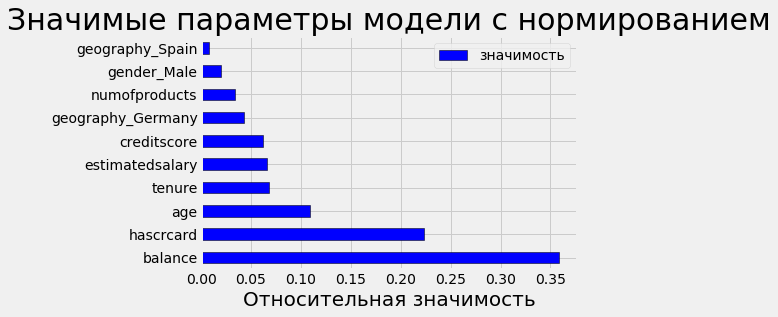

In [33]:
#найдем топ-10 признаков 
feature_results_1 = pd.DataFrame({'параметры': list(x_train.columns), 
                                'значимость': best_model_4.feature_importances_})
feature_results_1 = feature_results_1.sort_values('значимость', ascending = False).reset_index(drop=True)
#посторим график
plt.style.use('fivethirtyeight')
feature_results_1.loc[:9, :].plot(x = 'параметры', y = 'значимость', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue')
plt.xlabel('Относительная значимость', size = 20); plt.ylabel('')
plt.title('Значимые параметры модели с нормированием', size = 30)

Проверим баланс классов для тестовой и обучающей выборки

In [ ]:
print('Процент "1" от общего количества значений')
print(' - в обучающей выборке = ',y_train.sum()/len(y_train))
print(' - в тестовой выборке = ',y_test.sum()/len(y_test))

* Получили максимальный F1 score равный 62,1% на тестовой выброке для модели случайного леса без нормирования данных с парметрами: балансировка, максимальная глубина 7, количество деревьев 15

* Самым важным параметром лучшей модели оказался остаток на счете и наличие карты, что похоже на правду